<img src="escudo_utfsm.gif" style="float:right;height:100px">
<img src="IsotipoDIisocolor.png" style="float:left;height:100px">
<center>
    <h1> INF/ILI 285 Computación Científica I</h1>
    <h1> Tarea N°4: Extendiendo el Método de Newton </h1>
    <h3> [S]cientific [C]omputing [T]eam 2019</h3>
    <h3> Benjamín Sebastián Gautier Ortiz</h3>
    <h4> 201460036-4</h4>
    <h4> benjamin.gautier.14@sansano.usm.cl</h4>
    <h4> 10 de Septiembre, 2019</h4>
</center>

---

In [25]:
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from  scipy.linalg import lu
from  scipy.linalg import solve_triangular
from scipy.sparse import csr_matrix, identity
from scipy.linalg import solve_triangular as st
from scipy.sparse.linalg import gmres
import timeit

## Contexto

Un sistema de ecuaciones no lineales es un sistema en el cual la salida del problema no es linealmente proporcional a las entradas.
Este problema se puede representar vectorialmente de la siguiente manera:

\begin{equation*}
    \mathbf{F}(\mathbf{x})=\mathbf{y},
\end{equation*}

donde $\mathbf{F}:\mathbb{R}^n\rightarrow \mathbb{R}^n$ es una función no lineal, $\mathbf{x} \in \mathbb{R}^{n}$ e $\mathbf{y} \in \mathbb{R}^{n}$. Como se vio en clases, podemos solucionar este problema usando el método de *Newton multivariado*:

\begin{equation*}
    \mathbf{x_{k+1}}=\mathbf{x_k}-J_{\mathbf{G}}^{-1}(\mathbf{x_k})\mathbf{G}(\mathbf{x_k}),
\end{equation*}

donde $\mathbf{G}({\mathbf{x}})=\mathbf{F}(\mathbf{x})-\mathbf{y}=\mathbf{0}$, o sea, se está realizando una busqueda de raíces, y $J_{\mathbf{G}}(\mathbf{x_k}) \in \mathbb{R}^{n\times n}$ es la matriz jacobiana de $\mathbf{G}$. Para evitar calcular inversas, la iteración puede ser representada de la siguiente manera:
\begin{align}
    \mathbf{x_{k+1}} &= \mathbf{x_k}-\delta\mathbf{x_k}, \\
    J_{\mathbf{G}}(\mathbf{x_k})\delta\mathbf{ x_k} &= \mathbf{G}(\mathbf{x_k}).
\end{align}

### Sistema no lineal sobredeterminado

En la asignatura se aprendió a resolver sistemas no lineales con Newton multivariado cuando $\mathbf{F}$ va de $\mathbb{R}^n$ a $\mathbb{R}^n$. Ahora veremos como resolver el caso en el que $\mathbf{F}$ va de $\mathbb{R}^n$ a $\mathbb{R}^m$, con $m\geq n$.

Al desarrollar un problema de busqueda de raíces multivariado usando Newton multivariado, nos toparemos con que la matriz jacobiana $J_{\mathbf{G}}(\mathbf{x_k})$ tiene dimensiones $m\times n$, y por lo tanto debemos resolver un sistema sobredeterminado. Se introduce entonces el método de *Gauss-Newton*, el cual es similar el Método de Newton multivariado pero en vez de resolver el sistema de ecuaciones lineales sobredeterminado

$$
    J_{\mathbf{G}}(\mathbf{x}_k)\,\delta\mathbf{x}_k = \mathbf{G}(\mathbf{x}_k),
$$

resuelve el siguiente problema de mínimos cuadrados

$$
    \min_{\delta\mathbf{x}_k \in \mathbb{R}^n} \left\lVert J_{\mathbf{G}}(\mathbf{x}_k)\,\delta\mathbf{x}_k - \mathbf{G}(\mathbf{x}_k) \right\rVert_2^2.
$$

Para resolver esto, usaremos las ecuaciones normales:
\begin{equation*}
    J_{\mathbf{G}}^T(\mathbf{x_k})J_{\mathbf{G}}(\mathbf{x_k})\delta\mathbf{ x_k}=J_{\mathbf{G}}^T(\mathbf{x_k})\mathbf{G}(\mathbf{x_k}).
\end{equation*}

Para evitar tener matrices singulares, agregaremos una pequeña perturbación a la diagonal de la matriz $J_{\mathbf{G}}(\mathbf{x_k})^T\,J_{\mathbf{G}}(\mathbf{x_k})$ igual a un factor real no negativo $\lambda$ (denominado *factor de amortiguamiento*) por la matriz identidad. Esta modificación, introducida por Kenneth Levenberg, suele ser recalculada en cada iteración. Finalmente, nuestro algoritmo será:
\begin{align}
    \mathbf{x_{k+1}} &= \mathbf{x_k}-\delta\mathbf{x_k}, \\
    \left(J_{\mathbf{G}}^T(\mathbf{x_k})J_{\mathbf{G}}(\mathbf{x_k})+\lambda I\right)\delta\mathbf{ x_k} &= J_{\mathbf{G}}^T(\mathbf{x_k})\mathbf{G}(\mathbf{x_k}).
\end{align}

## Preguntas
---

Sea $m$ el número de ecuaciones y $n$ el número de incógnitas, llamaremos $F$ el sistema de funciones no lineales tal que su $i$-ésima ecuación se define como:

$$
    f_i(\mathbf{x}) = n + (j+1)\left(1 - \cos x_j + \sin x_j  \right) - \sin x_j - \frac{n}{3}\left( \cos x_j + \cos x_k + \cos x_w \right),
$$

donde $j = i\% n$, $k = (i+1) \% n$ y $w = (i+2) \% n$, y $\%$ es la operación _módulo_, la cual calcula el resto de la división entre un número y otro. Considere que el RHS del sistema es el vector nulo, esto es $F(\mathbf{x})=\mathbf{0}$.

## Sección 1 (20 puntos)

1. Calcule y muestre la estructura de la matriz Jacobiana del sistema entregado, considerando $m$ ecuaciones y $n$ variables. Implemente la rutina `evaluate_jacobian`, la cual debe retornar la matriz evaluada en el vector parámetro $\mathbf{x}$.

## Respuesta

Para responder esta pregunta primero vamos a expandir la función $f_i(\textbf{x})$:

$$
f_i(\textbf{x}) = n + j - j cos(x_j) + j sin(x_j) + 1 - cos(x_j) + sin(x_j) - sin(x_j) - \dfrac{n}{3} cos(x_j) - \dfrac{n}{3}( cos(x_k) + cos(x_w) ) 
$$

$$
f_i(\textbf{x}) = n + j - j cos(x_j) + j sin(x_j) + 1 - cos(x_j) - \dfrac{n}{3} cos(x_j) - \dfrac{n}{3}( cos(x_k) + cos(x_w) ) 
$$

Luego, para calcular el Jacobiano de la función $f_i(\textbf{x})$  debemos tener en cuenta la dimensión del vector $\textbf{x}$, digamos que la dimensión de éste es $nx1$, por lo que hay n variables en el vector. Lo anterior nos sirve para crear la matriz jacobiana, ya que ésta es una matriz cuadrada de $nxn$ en donde cada fila ( $f_i(\textbf{x}_k)$ ) debe ser derivado parcialmente con respecto a cada una de las variables del vector.

Por otro lado, notar que $f_i(\textbf{x})$ en cada fila tendrá a lo más 3 componentes no nulos, ya que la fórmula de la función toma 3 variables por cada fila de la matriz; por lo que solo calcularemos las derivadas parciales en donde sabemos que las variables estarán, para lo anterior definimos tres funciones para derivar:

$$
\begin{align}
\dfrac{\partial f_i(x_j)}{\partial x_j} &= j sin(x_j) + j cos(x_j) +\frac{n}{3} sin(x_j), \text{ con } j = i\%n\\
\dfrac{\partial f_i(x_k)}{\partial x_k} &= \frac{n}{3} sin(x_k), \text{ con } k = i+1\%n\\
\dfrac{\partial f_i(x_w)}{\partial x_w} &= \frac{n}{3} sin(x_w), \text{ con } w = i+2\%n\\
\end{align}
$$

En donde, resumidamente, se seguirá el siguiente patrón al calcular la Jacobiana:
$
(j,k,w) = \{(0,1,2),(1,2,3),(3,4,5),...,(0,n-1,n),(0,1,n)\}
$, lo que genera una matriz _sparse_ con una estructura como la siguiente; notar que cada elemento no nulo en las casillas se refiere a la derivada parcial de la función $f$ en la i-ésima fila con respecto a la variable $x_i$:

$$
J_G(\textbf{x}_k) = 
\begin{pmatrix}
a & b & c & 0 & 0 & 0 & 0\\\ 
0 & d & e & f & 0 & 0 & 0\\\
0 & 0 & g & h & i & 0 & 0\\\ 
0 & 0 & 0 & j & k & l & 0\\\
0 & 0 & 0 & 0 & m & n & ñ\\\ 
o & 0 & 0 & 0 & 0 & p & q\\\
r & s & 0 & 0 & 0 & 0 & t
\end{pmatrix}$$

In [20]:
partial_xj = lambda x_j,j,n: (j*np.sin(x_j) + j*np.cos(x_j) + np.sin(x_j) + (n/3)*np.sin(x_j) )
partial_xk = lambda x_k,n: (n/3)*np.sin(x_k)
partial_xw = lambda x_w,n: (n/3)*np.sin(x_w)
'''
Input: 
m - Number of equations of F
n - Number of variables
x - (array) Vector of dimension n
Output:
Jx - (double-array) Vector x evaluated in jacobian matrix of F. Its dimension is mxn 
'''
def evaluate_jacobian(m,n,x):
    Jx = np.zeros((m,n))
    if(n<=2): return Jx
    
    for i in range(0,m):
        j = i%n
        k = (i+1)%n
        w = (i+2)%n
        elem_j = partial_xj(x[j],j,n)
        elem_k = partial_xk(x[k],n)
        elem_w = partial_xw(x[w],n)
        Jx[i,j] = elem_j
        Jx[i,k] = elem_k
        Jx[i,w] = elem_w
        
    return Jx

2. Implemente el algoritmo de Gauss-Newton, con parámetro $\lambda = 0.0001$, que resuelva el sistema de ecuaciones lineales mediante PALU. Puede utilizar la implementación de `scipy` de PALU. Para esto utilice la firma entregada. Mida y grafique los tiempos de cómputo para las siguientes combinaciones de dimensiones:
    * 5000 ecuaciones y 3000 incógnitas.
    * 10000 ecuaciones y 6000 incógnitas.
    * 15000 ecuaciones y 9000 incógnitas.
   
   Si obtiene errores de memoria u obtiene tiempos de ejecución sobre los 5 minutos, comente al respecto. Puede variar el número de iteraciones en caso de altos tiempos de cómputo.

### Implementación

In [4]:
# F_i, la fila i-esima de el vector F(x)
F = lambda n,j,xj,xk,xw: n+(j+1)*(1-np.cos(xj)+np.sin(xj)) - np.sin(xj) - (n/3.0)*(np.cos(xj)+np.cos(xk)+np.cos(xw))

In [21]:
'''
Input:
m - Number of equations of F 
n - Number of variables
xs - data to evaluate in vector G
Output:
G(xs)
'''
def make_G(m,n,xs):
    g = np.zeros(m)
    
    for i in range(0,m-1):
        j = i%n
        k = (i+1)%n
        w = (i+2)%n
        g[i] = F(n,j,xs[j],xs[k],xs[w])
    return g

'''
Input:
A - Matriz of shape nxn
b - Vector of shape nx1
Output:
(x) solution for Ax=b with palu method
'''
def solve_palu(A, b):
    P,L,U = lu(A)
    b = np.dot(P.T,b)
    c = st(L,b,lower=True)
    x = st(U, c)
    return x

In [22]:
'''
Input: 
m - Number of equations of F
n - Number of variables
x0 - Initial guess
tol - Tolerance of root mean square error in order to return gauss-newton solution
max_it - Max. number of iterations
Output:
xk - (array) Solution vector of gauss-newton. Its dimension is n
'''
def gauss_newton_palu(m, n, x0, lamb=0.0001, tol=1e-5, max_it=10):
    xk = x0
    lambda_xk = np.zeros(n) #incognita
    
    for i in range(max_it):
        #get G(xk)
        g = make_G(m,n,xk)
        #stop if root mean square is less than tol
        if( (np.linalg.norm(g)/n) <= tol):
            break
        #get Jg(xk)
        Jg = evaluate_jacobian(m,n,xk)
        
        A = ((Jg.T).dot(Jg) + (lamb*np.identity(n)))
        b = (Jg.T).dot(g)
        
        #usar palu para resolver
        lambda_xk = solve_palu(A,b)
        xk_plus1 = xk - lambda_xk
        xk = xk_plus1
    return xk

In [23]:
'''
Show time solving sistem with palu
input:
max_iter: max number of iterations to gauss_newton_palu
'''
def plot_times_solving_palu(max_iter = 10):
    xs_plot = np.arange(3) + np.ones(3)
    
    ys = np.zeros(3)
    
    for i in range(1,4):
        xs = np.ones(3000*i)
        start = timeit.default_timer()
        gauss_newton_palu(i*5000,i*3000,xs,max_it=max_iter)
        stop = timeit.default_timer()
        ys[i-1]= stop - start
        
    plt.figure(figsize=(14, 7))
    plt.xticks([1,2,3], ["(5000x3000)", "10000x6000", "15000x9000"])

    plt.bar(xs_plot, ys, color=(0.3, 0.4, 0.6))

    plt.title("Sistema indeterminado con PALU, max_iter = {}".format(max_iter),size=16)
    plt.ylabel("Tiempo[segundos]")
    plt.xlabel("Tamaño del sistema (mxn)")

    # put text onside bar plot
    for i in range(len(xs_plot)):
        plt.text(x = xs_plot[i] - 0.2 , y = ys[i]+0.4, s = "t = {0:.2f}[seg]".format(ys[i]), size = 12)

    # Adjust the margins
    plt.subplots_adjust(bottom= 0.2, top = 0.98)


    plt.grid(True)
    plt.show()

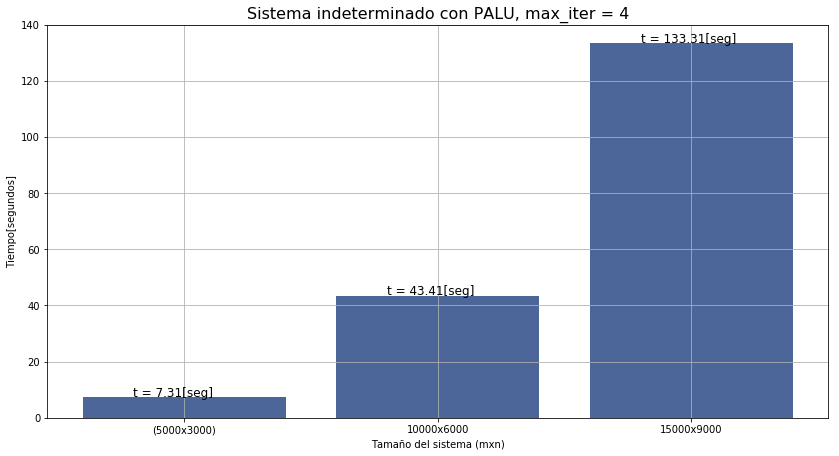

In [30]:
plot_times_solving_palu(4)

3. Realice el mismo experimento, pero utilizando GMRes. Considere la misma variación de dimensiones que en la pregunta anterior. Utilice la firma entregada. De igual manera, si tiene errores de memoria o tiempos de ejecución por sobre los 5 minutos, comente al respecto.

In [27]:
'''
Input: 
m - Number of equations of F
n - Number of variables
x0 - Initial guess
tol - Tolerance of root mean square error in order to return gauss-newton solution
max_it - Max. number of iterations
Output:
xk - (array) Solution vector of gauss-newton. Its dimension is n
'''
def gauss_newton_gmres(m, n, x0, lamb=0.0001, tol=1e-5, max_it=10):
    xk = x0
    
    lambda_xk = np.zeros(n) #incognita
    
    for i in range(max_it):
        #calculate G(xk)
        g = make_G(m,n,xk)
        #stop if root mean square is less than tol
        if( (np.linalg.norm(g)/n) <= tol):
            break
            
        #get Jg(xk)
        Jg = evaluate_jacobian(m,n,xk)
        
        A = ((Jg.T).dot(Jg) + (lamb*np.eye(n)))
        b = (Jg.T).dot(g)
        
        #solve with gmres
        lambda_xk,_ = gmres(A,b)
        xk_plus1 = xk - lambda_xk
        xk = xk_plus1
    
    return xk

In [28]:

def plot_times_solving_gmres(max_iter = 10):
    xs_plot = np.arange(3) + np.ones(3)
    
    ys = np.zeros(3)
    
    for i in range(1,4):
        xs = np.ones(3000*i)
        start = timeit.default_timer()
        gauss_newton_gmres(i*5000,i*3000,xs,max_it=max_iter)
        stop = timeit.default_timer()
        ys[i-1]= stop - start
    
    plt.figure(figsize=(14, 7))
    plt.xticks([1,2,3], ["(5000x3000)", "10000x6000", "15000x9000"])

    plt.bar(xs_plot, ys, color=(0.3, 0.4, 0.6))
    plt.title("Sistema indeterminado con GMRes, max_iter = {}".format(max_iter), size=16)
#     plt.plot( xs_plot, ys , ".b")
    plt.ylabel("Tiempo[segundos]")
    plt.xlabel("Tamaño sistema (mxn)")
        # Text on the top of each barplot

    for i in range(len(xs_plot)):
        plt.text(x = xs_plot[i] - 0.2 , y = ys[i]+0.2, s = "t = {0:.2f}[seg]".format(ys[i]), size = 12)

    # Adjust the margins
    plt.subplots_adjust(bottom= 0.2, top = 0.98)

    plt.grid(True)
    plt.show()

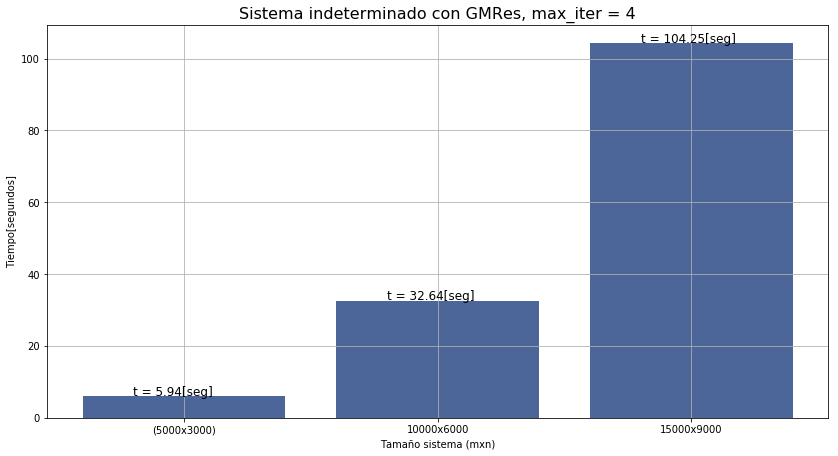

In [31]:
plot_times_solving_gmres(4)

4. Comente a partir de los resultados obtenidos.

Primero cabe mencionar que para que el método se detenga gracias a la tolerancia impuesta necesitamos iterar más veces el algoritmo, por lo que para las pruebas de esta pregunta se modificó la cantidad de iteraciones máximas para obtener un resultado, ya sea con PALU o con GMRes.

Por otro lado, con respecto a los tiempos de cómputo obtenidos con cada método podemos darnos cuenta que GMRes es más rápido que PA=LU en este problema en particular. 

Para explicar lo anterior debemos saber que hace cada método:

- PA=LU: Descompone la matriz A en una multiplicación de matrices factorizadas "L" y "U", donde se aplica la matriz de permutación "P" para siempre tener pivotes dominantes. Gracias a esta factorización podemos descomponer el sistema en dos sistemas lineales, y luego solucionar cada sistema  con un _forward-substitution_ y un _backward-substitution_.
- GMRes: Método iterativo para resolver sistemas lineales, el cual aproxima la solución del sistema lineal buscando minimizar el residuo dentro de un espacio (espacio de Krylov)

Dado lo anterior, podemos deducir que el método _newton extendido_ para este problema en particular tiene un mejor desempeño enfrentándolo con GMRes, esto puede ser debido a el número de condición existente en el Jacobiano de la función al aplicar la factorización PA=LU. Por otro lado, como GMRes busca minimizar el residuo en el espacio de Krylov, éste puede iterar más veces que PA=LU para llegar a una tolerancia deseada, lo que podría ser un factor determinante en la medición del tiempo, pero en el contexto actual de la tarea vemos que GMRes se comporta mejor gracias a la estructura de la matriz Jacobiana relacionada al problema.

## Sección 2 (35 puntos)

La matriz Jacobiana asociada al sistema de ecuaciones entregado posee la propiedad de que es *sparse*, por lo tanto es posible ahorrar almacenamiento y cómputo utilizando una estructura de datos adecuada. 

1. Modifique su implementación de cálculo de la matriz Jacobiana para que utilice una estructura de datos para matrices *sparse* [1].

2. Considere 35000 ecuaciones y 25000 incógnitas. Comente y justifique la factibilidad o infactibilidad de resolver ese problema mediante PALU.

3. Considere 35000 ecuaciones y 25000 incógnitas. Resuelva el problema mediante Gauss-Newton, resolviendo el sistema de ecuaciones lineales mediante GMRes, considerando matrices Jacobianas del tipo *sparse*. Considere un parámetro $\lambda = 0.0001$. Puede utilizar la implementación de GMRes de Scipy.

### Respuesta 1

Se cambia la estructura de datos de matriz de numpy a _csr-matrix_ de scipy, en donde esta última es para realizar cálculos de matrices con la propiedad sparse más rápido que con la estructura de numpy. Cabe mencionar que podemos compactar una matriz densa en una _csr-matrix_ también, pero para esta tarea sabemos que la estructura de la matriz Jacobiana asociada al sistema de ecuaciones es sparse, por lo que la utilizamos para optimizar cálculos y tener sistemas de ecuaciones mucho más grandes que con los que podríamos utilizar usando matrices de numpy.

In [9]:
'''
Input: 
m - Number of equations of F
n - Number of variables
x - (array) Vector of dimension n
Output:
Jx - (double-array) Vector x evaluated in jacobian matrix of F. Its dimension is mxn sparse 
'''
def evaluate_jacobian_sparse(m,n,x):
    Jx_sparse = csr_matrix((m, n))
    if(n<=2): return Jx_sparse
    
    for i in range(0,m):
        j = i%n
        k = (i+1)%n
        w = (i+2)%n
        #print("j:{},k:{},w:{}".format(j,k,w))
        elem_j = partial_xj(x[j],j,n)
        elem_k = partial_xk(x[k],n)
        elem_w = partial_xw(x[w],n)
        Jx_sparse[i,j] = elem_j
        Jx_sparse[i,k] = elem_k
        Jx_sparse[i,w] = elem_w
        
    return Jx_sparse

### Respuesta 2 - Comentario factibilidad de resolver sistema mediante PALU

Si utilizamos la tradicional forma de guardar las matrices, entonces PALU necesita de mucho espacio, si lo detallamos notamos lo siguiente:

- Matriz P: tamaño $nxn$
- Matriz L: tamaño $nxn$
- Matriz U: tamaño $nxn$
- Matriz A: tamaño $nxn$

Luego, el contexto de esta tarea es calcular sistemas de ecuaciones indeterminados los que hay que _transformarlos_ hacia sistemas de ecuaciones determinados. Por lo que si tenemos de input una matriz $A$ de $m x n$, ésta es transformada a una $\hat{A}$ de dimensión $n x n$. 

El paso siguiente es aplicar la factorización $P\hat{A}=LU$ del sistema, en donde tenemos 3 matrices nuevas (P, L, U), las cuales son de dimensión $n x n$ al igual que $\hat{A}$.

Por lo que si tenemos una matriz input $A$ de $(35000x25000)$, tenemos esta cantidad de elementos en memoria:

$$4*(35000x35000) + (35000x25000)$$ 

Si usamos un sistema operativo en el cual un número o elemento ocupa $8 (bytes)$ entonces tenemos :

$$(8*(35000)*(25000) + 8*4*(35000)*(35000)) (bytes)$$

Obteniendo un total de: 

$$ 2,57x10^{19} (bytes) == 2,57x10^{10} (GB) $$

Lo anterior es infactible ya que no existe computador con una memoria RAM con esa cantidad de espacio. 

### Respuesta 3

In [10]:
'''
Input: 
m - Number of equations of F
n - Number of variables
x0 - Initial guess
tol - Tolerance of root mean square error in order to return gauss-newton solution
max_it - Max. number of iterations
Output:
xk - (array) Solution vector of gauss-newton. Its dimension is n
'''
def gauss_newton_gmres_sparse(m, n, x0, lamb=0.0001, tol=1e-5, max_it=10):
    xk = x0
    
    lambda_xk = np.zeros(n) #incognita
    
    for i in range(max_it):
        #calculate G(xk)
        g = make_G(m,n,xk)
        
        if( (np.linalg.norm(g)/n) <= tol):
            break

        Jg = evaluate_jacobian_sparse(m,n,xk)
        
        left_eq = ((Jg.T)@(Jg) + (identity(n).dot(lamb)))
        
        right_eq = (Jg.T)@(g)
        
        lambda_xk,_ = gmres(left_eq,right_eq)
        xk_plus1 = xk - lambda_xk
        xk = xk_plus1
    return xk

In [60]:
x0 = np.ones(25000)
%time xk = gauss_newton_gmres_sparse(35000,25000,x0, max_it=2)

/home/bgautier/.local/lib/python3.7/site-packages/ipykernel_launcher.py:21: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
/home/bgautier/.local/lib/python3.7/site-packages/ipykernel_launcher.py:22: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
/home/bgautier/.local/lib/python3.7/site-packages/ipykernel_launcher.py:23: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.


CPU times: user 3min 50s, sys: 1.01 s, total: 3min 51s
Wall time: 3min 54s


In [61]:
xk

array([0.28104931, 0.22102948, 0.17080232, ..., 0.02897427, 0.01225405,
       0.00292047])

## Sección 3 (35 puntos)

1. Modifique el *widget* adjunto para que grafique el residuo $\lVert \mathbf{F}(\mathbf{x}_k) \rVert_2$ obtenido en cada iteración de su implementación de Gauss-Newton, y ejecútelo para distintos valores de $\lambda$, $m$ y $n$ . Comente sobre el efecto del parámetro de amortiguamiento al resolver el sistema de ecuaciones no lineales sobredeterminado.

In [18]:
def plot_nonlin_residual(lamb, m, n, tol):
    ## Solve the problem here using the given parameters
    m = int(m)
    n = int(n)
    xs = np.zeros(1)
    ys_gmres = np.ones(n)
    res_gmres = np.zeros(1)
    i = 0
    g = make_G(m,n,ys_gmres)
    while(np.linalg.norm(g)/n >= tol):
        res_gmres = np.append(res_gmres, [np.linalg.norm(g)] )
        xs = np.append(xs,[i])
        ys_gmres = gauss_newton_gmres_sparse(m,n,ys_gmres,lamb=lamb,max_it=1)
        g = make_G(m,n,ys_gmres)
        i += 1
    
    plt.figure(figsize=(14, 7))
    plt.semilogy(res_gmres, '.')
    
    plt.title("||F(x_k)|| vs iteraciones, GMRes", size=16)
    plt.xlabel("Iteraciones ")
    plt.ylabel("Norma del residuo")
    
    plt.grid(True)
    plt.show()

interact(
    plot_nonlin_residual, 
    lamb=(0.00001, 10, 0.00001),
    m=widgets.FloatText(description="Num. Equations: ", value=350),
    n=widgets.FloatText(description="Num. Unknowns : ", value=250),
    tol=widgets.FloatText(description="Tolerance: ", value=1e-5)
);

interactive(children=(FloatSlider(value=5.0, description='lamb', max=10.0, min=1e-05, step=1e-05), FloatText(v…

### Comentario 

Gracias al Widget podemos darnos cuenta que al variar el parámetro de amortiguación $\lambda$ del sistema de ecuaciones indeterminado podemos acelerar la convergencia a la solución. 

Haciendo variaciones en el parámetro para distintos sistemas de ecuaciones podemos darnos cuenta de:

- El sistema converge antes para un parámetro $\lambda$ pequeño.
- El sistema se demora un par de iteraciones más para un $\lambda$ más grande.

2. Modifique el siguiente *widget* para que grafique los residuos obtenidos al resolver los distintos sistemas de ecuaciones lineales con GMRes, en su implementación de Gauss-Newton. Ejecute el algoritmo para distintos valores de $\lambda$ y dimensiones, y comente al respecto.

In [19]:
def plot_linear_residual(lamb, m, n, tol, n_it=5):
    ## Solve the problem here using the given parameters
    n_it = int(n_it)
    plt.figure(figsize=(14, 7))
    n = int(n)
    m = int(m)
    ys_gmres = np.ones(n)
    
    for i in range(n_it):
        res_gmres = make_G(m,n,ys_gmres)
        if((np.linalg.norm(res_gmres)/n)  <= tol):
            break
        ys_gmres = gauss_newton_gmres_sparse(m,n,ys_gmres,lamb=lamb,tol=tol,max_it=1)
        plt.semilogy(res_gmres, '.')
        
    
    plt.title("F(x_k) vs x_k, GMRes", size=16)
    plt.ylabel("F(x_k)")
    plt.xlabel("Puntos x_i")
    
    plt.grid(True)
    plt.show()

interact(
    plot_linear_residual, 
    lamb=(0.00001, 10, 0.00001),
    m=widgets.FloatText(description="Num. Equations: ", value=350),
    n=widgets.FloatText(description="Num. Unknowns : ", value=250),
    tol=widgets.FloatText(description="Tolerance: ", value=1e-5),
    n_it = widgets.FloatText(description="Num. iterations : ", value=5)
);

interactive(children=(FloatSlider(value=5.0, description='lamb', max=10.0, min=1e-05, step=1e-05), FloatText(v…

### Comentario

Gracias al Widget anterior podemos darnos cuenta que al variar el parámetro de amortiguación $\lambda$ el residuo también lo hace, incluso observamos el siguiente comportamiento:

- Si $\lambda$ es grande, entonces el residuo llega a valores muy bajos y los valores resultantes que componen al vector solución están mas "juntos", por lo que en la solución hay menos dispersión de datos.
- Si $\lambda$ es pequeño, el residuo llega a valores bajos, pero mayores que si $\lambda$ fuera más grande; y los valores resultantes que componen el vector solución están mas dispersos.

Por otro lado, al variar la dimensión de la matriz asociada al problema observamos que el residuo sigue el mismo patrón, pero con más puntos representativos de la solución. 

Finalmente, observar el comportamiento del residuo del problema, el cual muestra que está convergiendo a la solución del sistema a la quinta iteración. 

*Observación*: Se ha modificado la firma de la función para limitar la cantidad de iteraciones del problema, dado que para que se detenga meiante condición de parada por tolerancia hacen falta más iteraciones, lo cual invisibiliza el resultado mediante los gráficos y se obtienen tiempos de cómputo altos.  

---
# Instrucciones:

* **Importante, Asegúrese de responder TODO lo que la pregunta pide.**
* La estructura de la tarea es la siguiente:
     1. Título, nombre de estudiante, email y rol.
     2. Responder cada pregunta de forma personal.
     5. Referencias. Es muy importante incluir todas las fuentes usadas, de otra forma se considera que lo no se ha citado adecuadamente es su trabajo.
* La tarea debe ser realizada en `Jupyter Notebook` (`Python3`) entregado.
* Recuerde responder la encuesta en el plazo establecido
* Se evaluará la correcta utilización de librerias `NumPy`, `SciPy`, `Matplotlib` y `ipywidgets`, entre otras, así como la **correcta implementación de algoritmos vectorizados**.
* **MUY IMPORTANTE** El archivo de entrega debe denominarse TareaN-rol.tar.gz y _notebook_ debe tener como nombre TareaN-rol.ipynb, donde $N$ es el número de la tarea y debe contener un directorio con todos los archivos necesarios para ejecutar el notebook, junto con un archivo README indicando explícitamente las librerías o módulos utilizados, nombre y rol del estudiante. Por cada error en este ambito implicará un descuento de 30 puntos.
* El descuento por día de atraso será de $30$ puntos, con un máximo de 1 día de atraso. No se recibirán entregas después de este día.
* Debe citar toda fuente de código externo. 
* El trabajo es personal, no se permite compartir código ni utilizar código de otros, aunque sí se sugiere discutir aspectos generales con sus compañeros.
* En caso de sospecha de no cumplimiento de estas instrucciones, se solicitará al involucrado o la involucrada a aclarar la situación. Dependiendo de la justificación se decidirá su calificación, la cual podrá o no ser penalizada.
* El no seguir estas instrucciones, implica descuentos en su nota obtenida.

# Referencias
[1] https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csr_matrix.html#scipy.sparse.csr_matrix

[2] https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.linalg.lu.html

[3] https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.sparse.linalg.gmres.html

[4] https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.solve_triangular.html

[5] https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.sparse.csr_matrix.html

[6] https://python-graph-gallery.com/10-barplot-with-number-of-observation/